## Data Mining project. **Ricardo Ibarra-Gil**  
---
### **Profiling of credit card clients**
### This is my first project on data analysis using unsupervised machine learning techniques in Python.
#### The objective is to analyze data on credit card usage of customers of a bank to identify profiles using Principal Components Analysis and clustering. Results are used to make recommendations to the bank about how to better target its clients with tailored offers and products

### Content
1. About the data
2. Data cleaning
3. Model 1. KMeans clustering, prior to PCA
4. PCA reduction
5. Model 2. KMeans clustering, using 8 components
6. Model 3. Hierarchical clustering, using 4 components
7. Recommendations
8. References

### 1. About the data
- Data set from Kaggle (https://www.kaggle.com/arjunbhasin2013/ccdata)
- It contains information about usage of credit cards from  approx. 9,000 clients of a bank, and 18 attributes, plus a unique customer identifier

#### Variables:
- CUSTID : Unique identifier  
- BALANCE : Monthly average balance in credit card (CC) statement  
- BALANCEFREQUENCY : Percentage of last 12 months with balance in CC statement  
- PURCHASES : Total purchase amount in last 12 months  
- ONEOFF_PURCHASES: Total amount of one-off purchases  
- INSTALLMENTS_PURCHASES: Total amount of installment purchases  
- CASH_ADVANCE: Total cash-advance amount  
- PURCHASES_FREQUENCY: Frequency of purchases (% of months with at least one purchase)  
- ONEOFF_PURCHASES_FREQUENCY: Frequency of one-off-purchases  
- PURCHASES_INSTALLMENTS_FREQUENCY: Frequency of installment purchases  
- CASH_ADVANCE_FREQUENCY: Cash-Advance frequency  
- AVERAGE_PURCHASE_TRX: Average amount per purchase transaction  
- CASH_ADVANCE_TRX: Average amount per cash-advance transaction  
- PURCHASES_TRX: Average amount per purchase transaction  
- CREDIT_LIMIT: Credit limit  
- PAYMENTS: Total payments in the period  
- MINIMUM_PAYMENTS: Total minimum payments due in the period  
- PRC_FULL_PAYMENT: Percentage of months with full payment of the due statement balance  
- TENURE: Number of months as a customer  


### 2. Data Cleaning

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
# from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram
import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline

In [3]:
CC_DF = pd.read_csv('CC GENERAL.csv', sep = ',')
CC_DF.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Some initial considerations about the data:
- There are 313 missing values in the data for MINIMUM_PAYMENTS, and 1 missing value for CREDIT_LIMIT  
- I set the MINIMUM_PAYMENTS missing values to the median of the variable and drop the missing value of CREDIT_LIMit  
- I also drop unique identifier

In [4]:
CC_DF['MINIMUM_PAYMENTS'].fillna((CC_DF['MINIMUM_PAYMENTS'].median()), inplace=True)
CC_DF['CREDIT_LIMIT'].fillna((CC_DF['CREDIT_LIMIT'].median()), inplace=True)
CC_DF.drop('CUST_ID', axis = 1, inplace = True)

In [5]:
CC_DF.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.282473,1733.143852,844.906767,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.646702,2895.063757,2332.792322,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,788.713501,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Next, I should do something about the outliers

#### Standarization

In the next table, it can be seen that the maximum value for some of the variables are far from the mean. For instance, the max value for MINIMUM_PAYMENTS is located 32.4 standard deviations away from the mean. This clearly points to the presence of outliers in the data.

In [6]:
CC_DF_Z = []
for i in CC_DF.columns:
    CC_DF_Z.append(((CC_DF.describe()[i][7]) - (CC_DF.describe()[i][1])) / CC_DF.describe()[i][2])
CC_DF_Z = pd.DataFrame(CC_DF_Z, columns = ['Standard deviations from the mean of MAX'])
CC_DF_Z.insert(0,'Variable',CC_DF.columns)
CC_DF_Z.sort_values(by = ['Standard deviations from the mean of MAX'], ascending = False)

,Variable,Standard deviations from the mean of MAX
14,MINIMUM_PAYMENTS,32.390925
4,INSTALLMENTS_PURCHASES,24.425524
3,ONEOFF_PURCHASES,24.199714
2,PURCHASES,22.482254
5,CASH_ADVANCE,22.009887
10,CASH_ADVANCE_TRX,17.546868
13,PAYMENTS,16.921334
11,PURCHASES_TRX,13.810243
0,BALANCE,8.397019
12,CREDIT_LIMIT,7.009671


I considered two methods for standarization of the data and dealing with outliers: 
- Robust Scaler
- Power Transformation  

In [7]:
CC_DF_max = CC_DF.describe()['MINIMUM_PAYMENTS'][7]
CC_DF_mean = CC_DF.describe()['MINIMUM_PAYMENTS'][1]
CC_DF_std = CC_DF.describe()['MINIMUM_PAYMENTS'][2]
CC_DF_z = (CC_DF_max - CC_DF_mean) / CC_DF_std
# Robust Scaler
transformer_RS = RobustScaler()
CC_RS = transformer_RS.fit_transform(CC_DF)
CC_RS = pd.DataFrame(CC_RS, columns = CC_DF.columns)
CC_RS_max = CC_RS.describe()['MINIMUM_PAYMENTS'][7]
CC_RS_mean = CC_RS.describe()['MINIMUM_PAYMENTS'][1]
CC_RS_std = CC_RS.describe()['MINIMUM_PAYMENTS'][2]
CC_RS_z = (CC_RS_max - CC_RS_mean) / CC_RS_std
# Power Transformation
transformer_PT = PowerTransformer()
CC_T = transformer_PT.fit_transform(CC_DF)
CC_T = pd.DataFrame(CC_T, columns = CC_DF.columns)
CC_T_max = CC_T.describe()['MINIMUM_PAYMENTS'][7]
CC_T_mean = CC_T.describe()['MINIMUM_PAYMENTS'][1]
CC_T_std = CC_T.describe()['MINIMUM_PAYMENTS'][2]
CC_T_z = (CC_T_max - CC_T_mean) / CC_T_std

To have an idea of the results, let's take the variable MINIMUM_PAYMNETS as example:  

In [8]:
table_1_CC_DF = [CC_DF_std, CC_DF_z]
table_1_CC_RS = [CC_RS_std, CC_RS_z]
table_1_CC_T = [CC_T_std, CC_T_z]
table_1 = pd.DataFrame([table_1_CC_DF, table_1_CC_RS, table_1_CC_T], columns = ['Standard deviation', 'Distance of Max to mean (stdv)']) 
table_1.insert(0,'Method', ['Original Data', 'Robust Scaler', 'Power Transformation'])
table_1

,Method,Standard deviation,Distance of Max to mean (stdv)
0,Original Data,2332.792322,32.390925
1,Robust Scaler,3.775626,32.390925
2,Power Transformation,1.000056,4.036337


The table above shows that, for MINIMUM_PAYMENTS variable:  
- The original data has a substantially large standard deviation, and the maximum value is 32.4 standard deviarions from the mean.  
- Robust Scaler decreases standard deviation (observations are closer to each oher), but the outliers are still far away.   
- Power transformation compacts data and brings outliers closer: the maximum value is now 4 standar deviations from mean.  

The following graph shows the effect of the power transofrmation on the distribution of the variable MINIMUM_PAYMENTS:

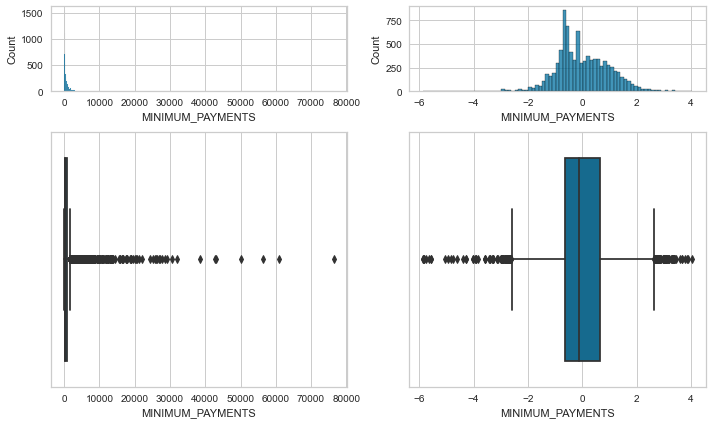

In [9]:
# Graph to compare original data woth transformed: one hist and one boxplot for each case
f, axs = plt.subplots(2,2, figsize = (10,6), sharex = False, gridspec_kw = dict(height_ratios = [1,3]))
sns.histplot(data = CC_DF, x = "MINIMUM_PAYMENTS", ax = axs[0,0], legend = False)
sns.boxplot(data = CC_DF, x = "MINIMUM_PAYMENTS", ax = axs[1,0])
sns.histplot(data = CC_T, x ="MINIMUM_PAYMENTS", ax = axs[0,1], legend = False)
sns.boxplot(data = CC_T, x = "MINIMUM_PAYMENTS", ax = axs[1,1])
f.tight_layout()

For the graph above, the left hand side represents the variable's original distribution, which ranges from 0 to 8,950, with a median of 312.3.
The right hand side graph shows the distribution after the power transformation. Now, the variable ranges from -5.8 to 8.9, and its maximum value is 4.0 standard deviations away from its mean. We now have data more concentrated around its central values.

The following graph is the equivalent of the graph above, but for another variable: BALANCE.
Similar conclusions can be drawn from it.

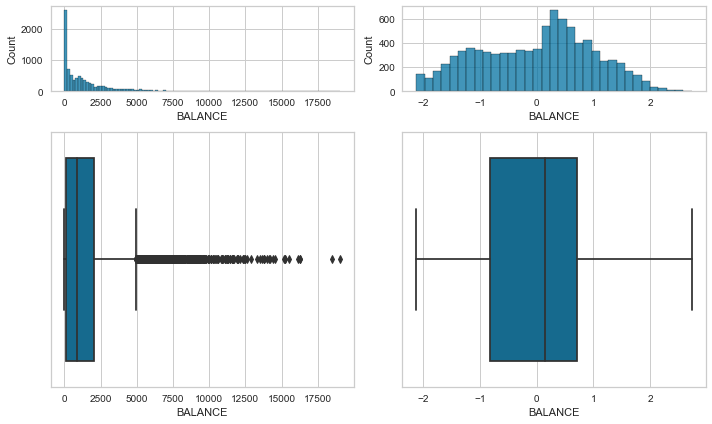

In [10]:
f, axs = plt.subplots(2,2, figsize = (10,6), sharex = False, gridspec_kw = dict(height_ratios = [1,3]))
# makde density plot along x-axis without legend
sns.histplot(data = CC_DF, x = "BALANCE", ax = axs[0,0],legend = False)
sns.boxplot(data = CC_DF, x = "BALANCE", ax = axs[1,0])
sns.histplot(data = CC_T, x ="BALANCE", ax = axs[0,1], legend = False)
sns.boxplot(data = CC_T, x = "BALANCE", ax = axs[1,1])
f.tight_layout()

As a final comment on the descriptive statitics of the data, following correlation heatmap shows some expected correlations, such as the ones between the variables levels, their frequencies (_FREQUENCY) and their average amount per transaction (_TRX_).  
Interestingly enough, PRC_FULL_PAYMENT (how frequently the client pays its amount due totally) has negative correlations with some other variables such as: 
- BALANCE (average monthly balance in the client's card)  
- CASH_ADVANCE and CHAS_ADVANCE_TRX (how much the client asks for cash advance form its credit card)  
- MINIMUM_PAYMENTS (total minimum payment due)

<AxesSubplot:>

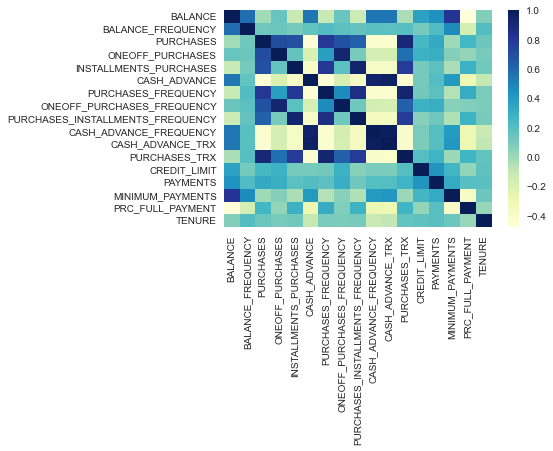

In [11]:
sns.heatmap(CC_T.corr(), cmap= 'YlGnBu')

### 3. Model 1. KMeans clustering, prior to PCA
The attempt to find patterns in the data will be fitting a K Means clustering model with the cleaned and power transformed data.  

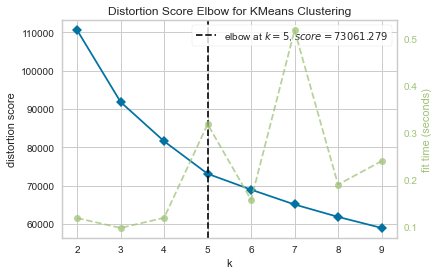

In [12]:
C_model_0 = KMeans(random_state = 1)
# Perform K Elbow with k from 2 to 20
visualizer = KElbowVisualizer(C_model_0, k = (2,10), timings = True)
visualizer.fit(CC_T)
visualizer.show();

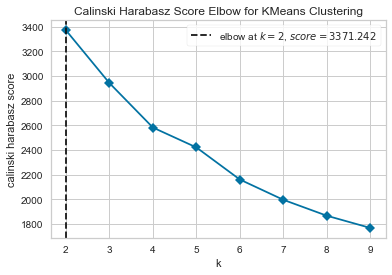

In [13]:
# Perform K Elbow with calinski harabasz, with k from 2 to 2
visualizer = KElbowVisualizer(C_model_0, k = (2,10), metric = 'calinski_harabasz',locate_elbow = True, timings = False)
visualizer.fit(CC_T)
visualizer.show();

Elbow criterion points towards 5 clusters as a good spcification for minimizing the within cluster variation, while Calinksi-Harabasz (variance ratio) points to k = 2.
Additional metrics for k = 5 point towards using this number of clusters. I call this model, **model_1:**

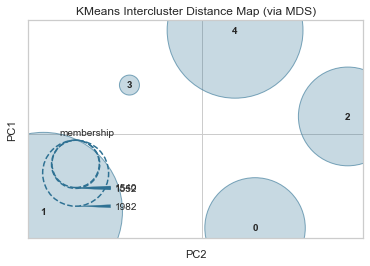

In [14]:
C_model_1 = KMeans(random_state = 1, n_clusters = 5, init = 'k-means++', verbose = 0) # default number of clusters = 8
visualizer = InterclusterDistance(C_model_1)
visualizer.fit(CC_T) 
visualizer.show();  

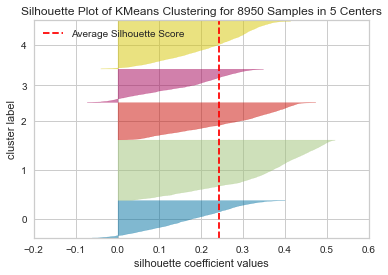

In [15]:
visualizer = SilhouetteVisualizer(C_model_1, colors='yellowbrick')
visualizer.fit(CC_T) 
visualizer.show();  

- Intercluster distance shows different data membership from the clusters, but no overlapping in the reduced 2-dimension representation of clusters. 
- Silhouette scores visualization show all clusters reach the average silhouette score; clusters 0, 3 and 4 have a few observations with negative  silhouette, meaning that they might not belong to those clusters. Overall, I believe it shows a good density of the clusters.


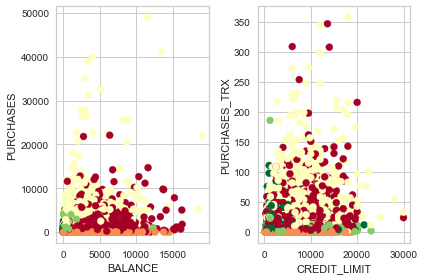

In [16]:
plt.subplot(1, 2, 1)
plt.scatter(CC_DF['BALANCE'], CC_DF["PURCHASES"], c = C_model_1.labels_, alpha  = 1, cmap = 'RdYlGn')
plt.xlabel("BALANCE")
plt.ylabel('PURCHASES')
plt.subplot(1, 2, 2)
plt.scatter(CC_DF['CREDIT_LIMIT'], CC_DF["PURCHASES_TRX"], c =C_model_1.labels_, alpha  = 1, cmap= 'RdYlGn')
plt.xlabel("CREDIT_LIMIT")
plt.ylabel('PURCHASES_TRX')
plt.tight_layout()
plt.show()


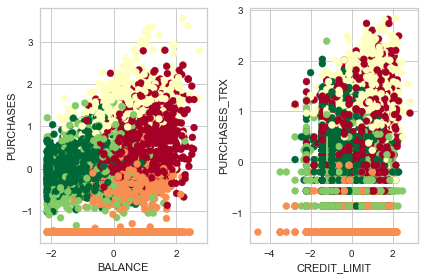

In [17]:
colors = np.array(["red","green","blue","pink","orange","magenta","purple","cyan"])
plt.subplot(1, 2, 1)
plt.scatter(CC_T['BALANCE'], CC_T["PURCHASES"], c = C_model_1.labels_, alpha  = 1, cmap = 'RdYlGn')
plt.xlabel("BALANCE")
plt.ylabel('PURCHASES')
plt.subplot(1, 2, 2)
plt.scatter(CC_T['CREDIT_LIMIT'], CC_T["PURCHASES_TRX"], c = C_model_1.labels_, alpha  = 1, cmap = 'RdYlGn')
plt.xlabel("CREDIT_LIMIT")
plt.ylabel('PURCHASES_TRX')
plt.tight_layout()
plt.show()

However, when the data is plotted with the resulting clusters, it is difficult to draw any conclusions, since the clusters overlap in almost all combinations of variables.

### 4. Principal Components Analysis (PCA)
An alternative to improve the results of the analysis is to apply dimension reduction with Principal Component Analysis (PCA).  
I run PCA setting the number of components to 8.

In [18]:
# Loading vectors
PCA_lv_1 = pd.DataFrame(PCA(n_components = 8).fit(CC_T).components_.T, index=CC_T.columns, 
columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8'])
#PCA model (object in python)
PCA_1 = PCA(n_components = 8)
#We fit and transform X to get the principal components from PCA
df_pca = pd.DataFrame(PCA_1.fit_transform(CC_T), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], index=CC_RS.index)

The resulting **loadings** for all 17 varaibles are graphed over PC1 the main two principal components (PC1, PC2).  
I will come back later to the loadings, its interpretation and use.

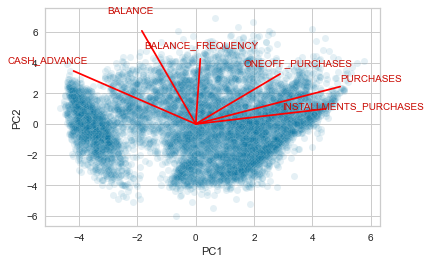

In [19]:
sns.scatterplot(data = df_pca, x = 'PC1', y = 'PC2', alpha = .1)
plt.xlabel("PC1")
plt.ylabel('PC2')
for i in np.arange(0,6):    
    sns.lineplot(x = [0, 14*PCA_lv_1['V1'][i]] , y = [0, 14*PCA_lv_1['V2'][i]], color = 'red')
    plt.text(PCA_lv_1['V1'][i]*17, PCA_lv_1['V2'][i]*17, str(PCA_lv_1.index[i]), horizontalalignment='center', color ='r', verticalalignment='center')

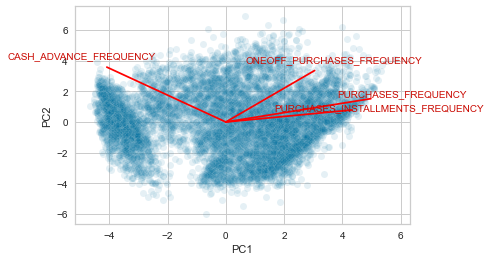

In [20]:
sns.scatterplot(data = df_pca, x = 'PC1', y = 'PC2', alpha = .1)
plt.xlabel("PC1")
plt.ylabel('PC2')
for i in np.arange(6,10):    
    sns.lineplot(x = [0, 14*PCA_lv_1['V1'][i]] , y = [0, 14*PCA_lv_1['V2'][i]], color = 'red')
    plt.text(PCA_lv_1['V1'][i]*17, PCA_lv_1['V2'][i]*17, str(PCA_lv_1.index[i]), horizontalalignment='center', color ='r', verticalalignment='center')

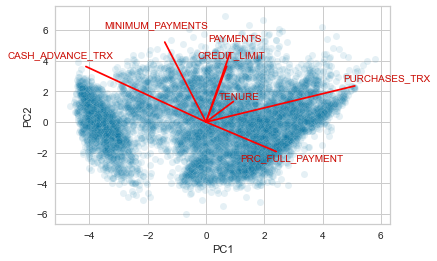

In [21]:
sns.scatterplot(data = df_pca, x = 'PC1', y = 'PC2', alpha = .1)
plt.xlabel("PC1")
plt.ylabel('PC2')
for i in np.arange(10,17):    
    sns.lineplot(x = [0, 14*PCA_lv_1['V1'][i]] , y = [0, 14*PCA_lv_1['V2'][i]], color = 'red')
    plt.text(PCA_lv_1['V1'][i]*17, PCA_lv_1['V2'][i]*17, str(PCA_lv_1.index[i]), horizontalalignment='center', color ='r', verticalalignment='center')

### 5. Model 2. KMeans clustering, using 8 components
Once I have the results of applying PCA to the data, I run a Kmeans  clustering model using all 8 components.

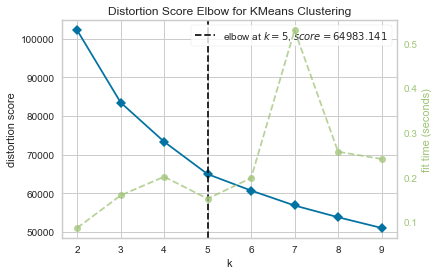

In [22]:
CLUSTER_ALL = df_pca
#Create a Kmeans model
C_model_ALL = KMeans(random_state = 1)

# Perform K Elbow with k from 2 to 10
visualizer = KElbowVisualizer(C_model_ALL, k = (2,10), timings = True)
visualizer.fit(CLUSTER_ALL)
visualizer.show(); 

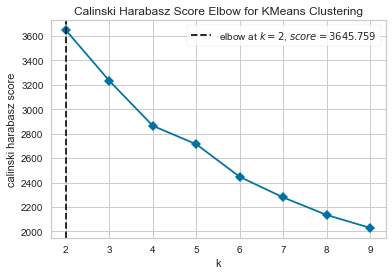

In [23]:
# Perform K Elbow with calinski harabasz, with k from 2 to 10
visualizer = KElbowVisualizer(C_model_ALL, k = (2,10), metric = 'calinski_harabasz',locate_elbow = True, timings = False)
visualizer.fit(CLUSTER_ALL)
visualizer.show();

After running models, and thorough revision, 4 clusters were selected as best parameter.

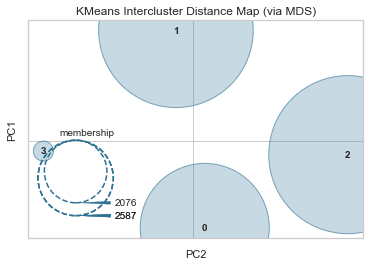

In [24]:
C_model_ALL_2 = KMeans(random_state = 1, n_clusters = 4, init = 'k-means++', verbose = 0) # default number of clusters=8
C_model_ALL_2.fit(CLUSTER_ALL)

visualizer = InterclusterDistance(C_model_ALL_2)
visualizer.fit(CLUSTER_ALL) 
visualizer.show();  


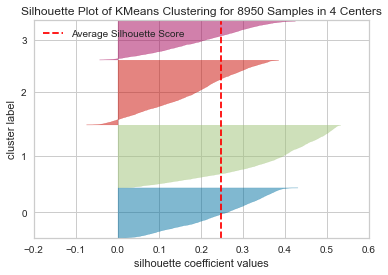

In [25]:
visualizer = SilhouetteVisualizer(C_model_ALL_2, colors='yellowbrick')
visualizer.fit(CLUSTER_ALL) 
visualizer.show();   

The model with 4 clusters has a relatively good performance in both intercluster distance and silhouette score metrics.

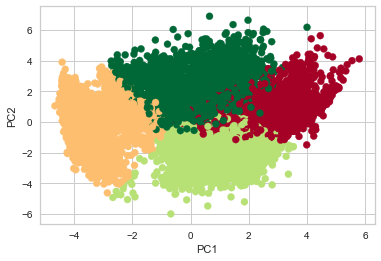

In [26]:
plt.scatter(CLUSTER_ALL['PC1'], CLUSTER_ALL['PC2'], c = C_model_ALL_2.labels_, alpha  = 1, cmap = 'RdYlGn')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

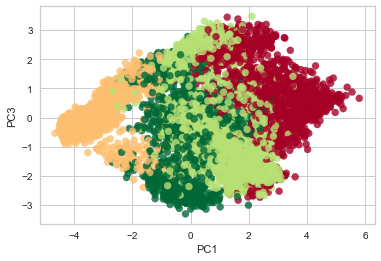

In [27]:
plt.scatter(CLUSTER_ALL['PC1'], CLUSTER_ALL['PC3'], c = C_model_ALL_2.labels_, alpha = 0.8, cmap = 'RdYlGn')
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.show()

And the results seem more interpretable, we could start trying to give some interpretation to the clusters.
However, when we begin using the components in the higher end (Components 5, 6, 7...), the clusters are not very well defined

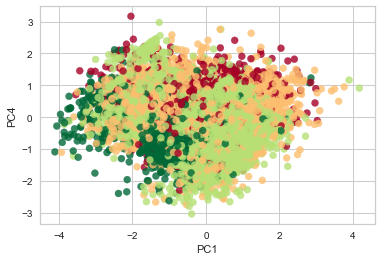

In [28]:
plt.scatter(CLUSTER_ALL['PC5'], CLUSTER_ALL['PC7'], c = C_model_ALL_2.labels_, alpha = 0.8, cmap = 'RdYlGn')
plt.xlabel("PC1")
plt.ylabel("PC4")
plt.show()

So it all stops making much sense, then maybe we should go back, and stick to only some components.
But how many?

### Further tuning... keep only 4 PC's 


In [29]:
var_explained = []
suma = 0
for i in range(0, len(PCA_1.explained_variance_ratio_)):
    suma += PCA_1.explained_variance_ratio_[i]
    var_explained.append(suma)
print(f'Variance in all 8 components explain {suma: .2%} of total variance in the data')

Variance in all 8 components explain  94.52% of total variance in the data


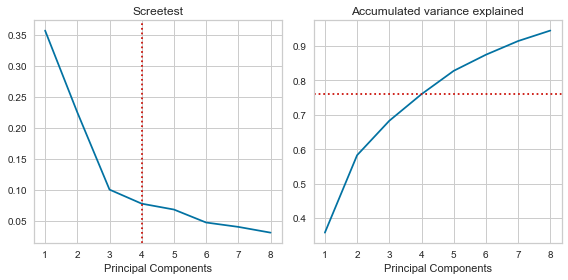

In [30]:
# Define optimal number of components
optimal_PC = 4
f, axs = plt.subplots(1,2, figsize = (8,4))
sns.lineplot(x = np.arange(1,9), y = PCA_1.explained_variance_ratio_, ax = axs[0])
sns.lineplot(x = np.arange(1,9), y = var_explained, ax = axs[1])
axs[0].set_title("Screetest")
axs[1].set_title("Accumulated variance explained")
axs[0].set_xlabel('Principal Components')
axs[1].set_xlabel('Principal Components')
axs[0].axvline(x = optimal_PC, color='r', linestyle=':')
axs[1].axhline(y = var_explained[(optimal_PC-1)], color='r', linestyle=':')
f.tight_layout()

I take only the first 4 components. Since: 
- Variance of components explains 76.0% of variance of explained variables (right hand side graph)
- 5th component marginal contribution is only 6.7%, so we have a decreased marginal contribution to the explanation of data variance (left hand side graph)

Now, back to the **loadings!**  
They represent the relation between variables and components, and are useful to give meaning to our 4 components.  
- I set a threshold, and display only loadings greater than |0.28|:

In [31]:
PCA_lv_1.iloc[:, : optimal_PC][(PCA_lv_1 > 0.28) | (PCA_lv_1 < -0.28)].fillna('-')

,V1,V2,V3,V4
BALANCE,-,0.433761,-,-
BALANCE_FREQUENCY,-,0.30332,-,-0.356114
PURCHASES,0.353849,-,-,-
ONEOFF_PURCHASES,-,-,0.50492,-
INSTALLMENTS_PURCHASES,0.317172,-,-0.389956,-
CASH_ADVANCE,-0.299421,-,-,0.292591
PURCHASES_FREQUENCY,0.355422,-,-,-
ONEOFF_PURCHASES_FREQUENCY,-,-,0.470402,-
PURCHASES_INSTALLMENTS_FREQUENCY,0.309445,-,-0.447063,-
CASH_ADVANCE_FREQUENCY,-0.291577,-,-,0.298498


In [32]:
PCA_lv_1.iloc[:, : optimal_PC][(PCA_lv_1 > 0.2) | (PCA_lv_1 < -0.2)].fillna('-')

,V1,V2,V3,V4
BALANCE,-,0.433761,-,-0.202673
BALANCE_FREQUENCY,-,0.30332,-,-0.356114
PURCHASES,0.353849,-,-,-
ONEOFF_PURCHASES,0.206607,0.232952,0.50492,-
INSTALLMENTS_PURCHASES,0.317172,-,-0.389956,-
CASH_ADVANCE,-0.299421,0.246894,-,0.292591
PURCHASES_FREQUENCY,0.355422,-,-0.202716,-
ONEOFF_PURCHASES_FREQUENCY,0.217632,0.239714,0.470402,-
PURCHASES_INSTALLMENTS_FREQUENCY,0.309445,-,-0.447063,-
CASH_ADVANCE_FREQUENCY,-0.291577,0.255491,-,0.298498


**Definition of components (interpretation) from the information of our loadings**  

1. **PC1: Intensiveness of credit card use, especially for big amounts in installments, and not for cash advance.**  
Total purchase amount in last year is high. The total amount spent in the last year is high, and the amount per transaction is also high. Purchases amount in installments during last year is also high Frequency of purchases overall and in installments is high, meaning most months has at least one purchase

2. **PC2: Indebtedness. The purchases are not high, but the balance is.**  
High monthly average balance, they have accumulated debt. The number of months with balance is high, frequently having balance, so is having debt all moths High amount due and paid by the customer to reduce their balance total minimum payments due are also high, so payments are being made, but still has balance

3. **PC3: Buying in one-off, no installments.**  
One off purchases amount are high, and installments purchases amount are low Not using card for installments, only for one off purchases Exact same relation but with the frequency

4. .**PC4: Pay card in full, and use it especially for cash in advance: being a relatively new client.**  
Paying card in total every month is a high feature in component Tenure is low, relatively new clients Also using credit card for asking cash advance. And not using card every month, negatively related to frequency

Having the four components interpreted, in the following graph we can see that maybe some concentrations of data (shadows) might become clusters in our clustering analysis

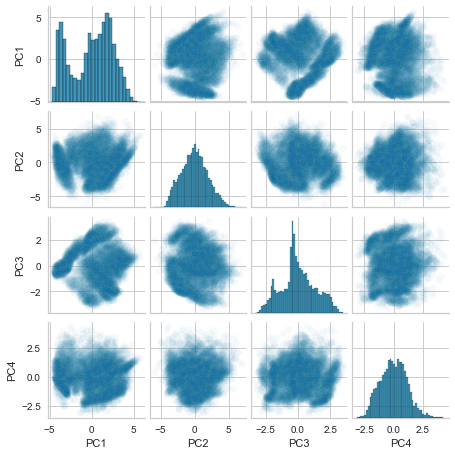

In [33]:
sns.pairplot(df_pca[['PC1', 'PC2', 'PC3', 'PC4']], kind = "scatter", plot_kws = dict(alpha = 0.03), height = 1.6)


In [34]:
# Select only the fist (optimal) Components, in this case 4
CLUSTER_X = df_pca.iloc[:,:optimal_PC]

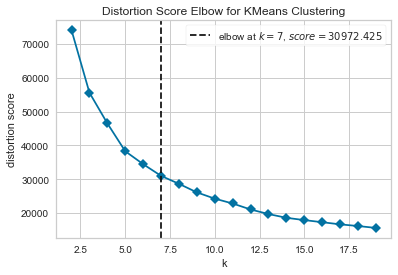

In [35]:
#Create a Kmeans model
C_model_2 = KMeans(random_state = 1)

# Perform K Elbow with k from 2 to 20
visualizer = KElbowVisualizer(C_model_2, k = (2,20), timings = False)
visualizer.fit(CLUSTER_X)
visualizer.show(); 

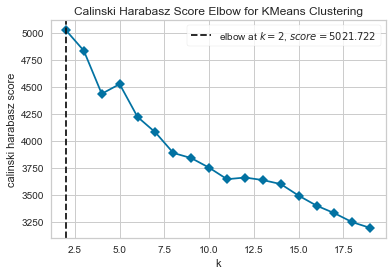

In [36]:
# Perform K Elbow with calinski harabasz, with k from 2 to 2
visualizer = KElbowVisualizer(C_model_2, k = (2,20), metric = 'calinski_harabasz',locate_elbow = True, timings = False)
visualizer.fit(CLUSTER_X)
visualizer.show();

We know our best number of cluster is between 2 and 7.  
However, we get best results in terms of our intercluster distance and silohuette score with 3 clusters.  
We use then 3 clusters.

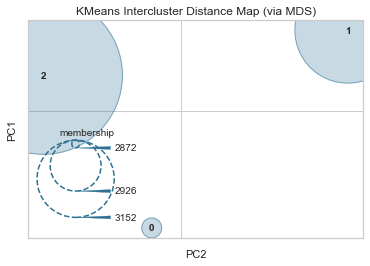

In [37]:
C_model_3 = KMeans(random_state = 1, n_clusters = 3, init = 'k-means++', verbose = 0)
C_model_3.fit(CLUSTER_X)

visualizer = InterclusterDistance(C_model_3)
visualizer.fit(CLUSTER_X)
visualizer.show();    

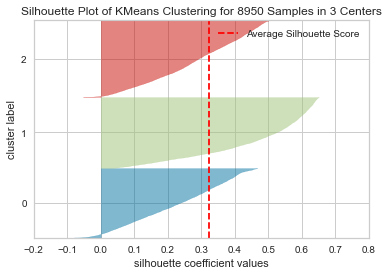

In [38]:
visualizer = SilhouetteVisualizer(C_model_3, colors = 'yellowbrick')
visualizer.fit(CLUSTER_X) 
visualizer.show(); 

We observe silhouette scores that are positive: all three clusters with data that fall beyond the average silohuette score, and very few data with silhouette score less than zero.

In [39]:
# Create dictionary for 3D graph labels
names = ['C1: Intensiveness (installments)', 'C2: Indebtedness', 'C3: Purchasing one-off', 'C4: Pay in full']
PCA = ['PC1', 'PC2', 'PC3', 'PC4']
names_PCA = dict(zip(PCA, names))

In [40]:
# 3D graph
# fig = px.scatter_3d(CLUSTER_X, x='PC1', y='PC2', z='PC3', color = C_model_3.labels_.astype(str), labels=names_PCA)
# fig.show()

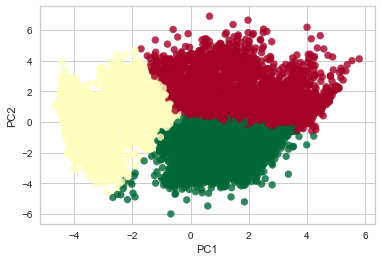

In [41]:
plt.scatter(CLUSTER_X['PC1'], CLUSTER_X['PC2'], c=C_model_3.labels_, alpha = 0.8, cmap = 'RdYlGn')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

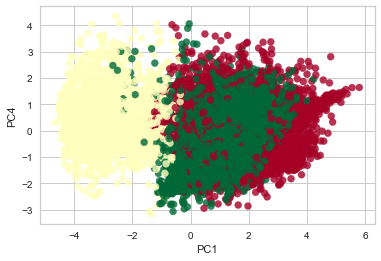

In [42]:
plt.scatter(CLUSTER_X['PC1'], CLUSTER_X['PC4'], c = C_model_3.labels_, alpha = 0.8, cmap = 'RdYlGn')
plt.xlabel("PC1")
plt.ylabel("PC4")
plt.show()

Results... show interesting ...
Finally, I will use hierarchical clustering

### Model 3. Hierarchical clustering with 3 clusters, 4 PC's, and ward linkage

We will use only ward linkage. complete, single and average were tried: average and single were suffering serious problems, and complete and ward led similar results.

DENDROGRAM: Selected three cluster, to cut the dendrogram around 160.

In [43]:
# The following code was fully taken from here: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

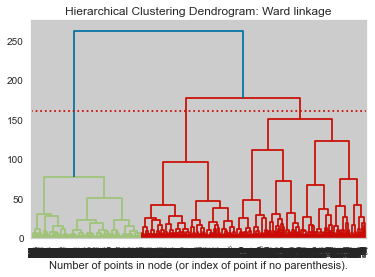

In [44]:
CLUSTER_X = df_pca.iloc[:,:4]
C_model_5 = AgglomerativeClustering(distance_threshold = 0, n_clusters = None, linkage = 'ward')
C_model_5.fit_predict(CLUSTER_X)
plt.title("Hierarchical Clustering Dendrogram: Ward linkage")
plot_dendrogram(C_model_5, truncate_mode="level", p = 12)
plt.axhline(y = 160, color='r', linestyle=':')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

We will use three clusters with ward linkage hierarchical clustering

In [45]:
C_model_10 = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')
C_model_10.fit_predict(CLUSTER_X)

array([0, 1, 0, ..., 0, 1, 2])

In [46]:
# # Grafica en 3d
# fig = px.scatter_3d(CLUSTER_X, x='PC1', y='PC2', z='PC3', color = C_model_10.labels_.astype(str), 
#                     labels=names_PCA)
# fig.show()

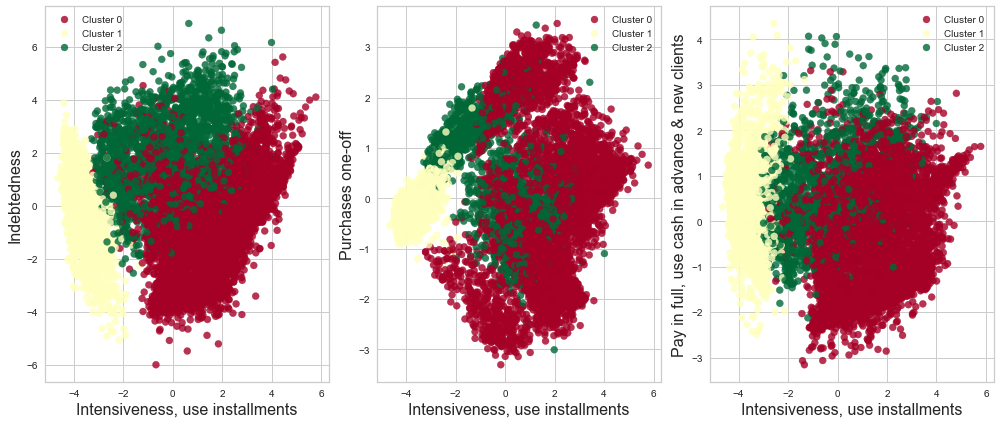

In [49]:
classes = ['Cluster 0', 'Cluster 1', 'Cluster 2']
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
scatter_0 = ax[0].scatter(CLUSTER_X['PC1'], CLUSTER_X['PC2'], c = C_model_10.labels_, alpha = .8, cmap = 'RdYlGn')
ax[0].set_xlabel("Intensiveness, use installments", fontsize = 16)
ax[0].set_ylabel("Indebtedness", fontsize = 16)
ax[0].legend(handles = scatter_0.legend_elements()[0], labels = classes)
scatter_1 = ax[1].scatter(CLUSTER_X['PC1'], CLUSTER_X['PC3'], c = C_model_10.labels_, alpha = 0.8, cmap = 'RdYlGn')
ax[1].set_xlabel("Intensiveness, use installments", fontsize = 16)
ax[1].set_ylabel("Purchases one-off", fontsize = 16)
ax[1].legend(handles = scatter_1.legend_elements()[0], labels = classes)
scatter_2 = ax[2].scatter(CLUSTER_X['PC1'], CLUSTER_X['PC4'], c = C_model_10.labels_, alpha = 0.8, cmap = 'RdYlGn')
ax[2].set_xlabel("Intensiveness, use installments", fontsize = 16)
ax[2].set_ylabel("Pay in full, use cash in advance & new clients", fontsize = 16)
ax[2].legend(handles = scatter_2.legend_elements()[0], labels = classes)
plt.tight_layout()
plt.show()

- Cluster 0 (red) is mostly in the mid-lower end of indebtedness, with few observations in the upper part. It also comprises observations in the medium to high range of intensiveness of use, especially in installments, all the range of purchases in one - off, and the middle and lower range of pay in full.
- Cluster 1 (yellow) is well defined as those who have lower intensiveness of use, especially in purchasing in installments. It is also distributed all along indebtedness and pay in full (especially using the card for cash in advance, and new clients).
- Cluster 2 (green) has most of its data points in the higher end of indebtedness and in the middle part of intensiveness of use.

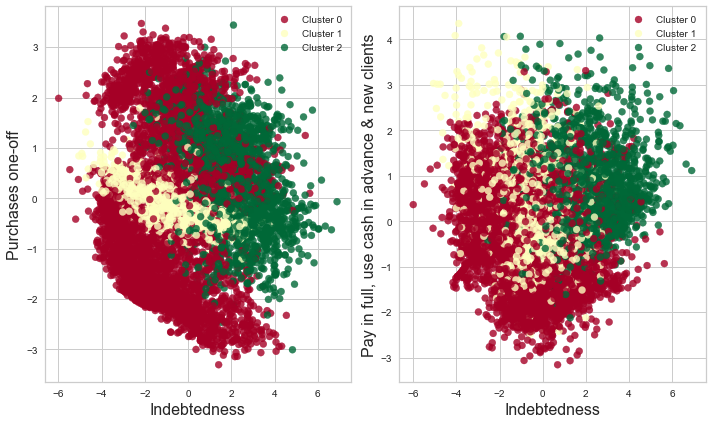

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
scatter_0 = ax[0].scatter(CLUSTER_X['PC2'], CLUSTER_X['PC3'], c = C_model_10.labels_, alpha = 0.8, cmap = 'RdYlGn')
ax[0].set_xlabel("Indebtedness", fontsize = 16)
ax[0].set_ylabel("Purchases one-off", fontsize = 16)
ax[0].legend(handles = scatter_0.legend_elements()[0], labels = classes)
scatter_1 = ax[1].scatter(CLUSTER_X['PC2'], CLUSTER_X['PC4'], c = C_model_10.labels_, alpha = 0.8, cmap = 'RdYlGn')
ax[1].set_xlabel("Indebtedness", fontsize = 16)
ax[1].set_ylabel("Pay in full, use cash in advance & new clients", fontsize = 16)
ax[1].legend(handles = scatter_1.legend_elements()[0], labels = classes)
plt.tight_layout()
plt.show()

From this second set of graphs that shows components 2, 3 and 4, conclusions are a bit more fuzzy or unclear, because clusters 0 and 1 (blue and green) show overlapping. But we can still see:
- Cluster 0 (red) is somewhat more concentrated towards the low part of pay in full compared esepcially to cluster 2 (green)
- Cluster 0 again appears covering all the range of purchases one-off.
- Cluster 1 (yellow) is concentrated in the middle part of purchases one-off
- Cluster 2 (green) is concentrated in the middle part of indebtedness

In [ ]:
# C_model_10 = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')
# C_model_10.fit_predict(CLUSTER_X)
# fig = px.scatter_3d(CLUSTER_X, x='PC1', y='PC3', z='PC4', color = C_model_10.labels_.astype(str), 
#                     labels=names_PCA)
# fig.show()

In [ ]:
# C_model_10 = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')
# C_model_10.fit_predict(CLUSTER_X)
# fig = px.scatter_3d(CLUSTER_X, x='PC2', y='PC3', z='PC4', color = C_model_10.labels_.astype(str), 
#                     labels=names_PCA)
# fig.show()

From the information of the graphs, and remembering our definition of the Components, we can try to define our clients profile for very cluster:

**Cluster 0**  

- People who use their credit card somewhat intensively: their frequency of purchases is high. 
- They tend to use their credit cards for large amounts, and in installments.
- They are located in the middle part of indebtedness. They pay their balances but not completely.
- These clients have a middle tendency to pay their credit cards in full and do not use much their cards for cash in advance.

**Cluster 1**  

- Clients who use their cards less frequently.
- Their level of indebtedness is average. Again, it could be due to their lower intesiveness of credit card use.
- They do not tend to buy in installments, and they are located right in the middle range of buying one-off purchases.
- Their data points are located all along the use of cash in advance and payment their card in full.

**Cluster 2** 

- Clients in the middle to lower spectrum of intensiveness of use: these clients have an average frequency of credit card use.
- In the middle to high end of indebtedness: they have high balance in their cards.
- The data points of this cluster are located in the middle to high end of tendency to pay in full, which could be counterintuitive to the fact that they are also middle-high in indebtedness. So, the fact that cluster 2 data points are in the middle upper part of component 4 could be explained rather by other factors included in that component, such as: use of credit card for cash in advance, not using their card very frequently, and being relatively newer clients.

Having described the clusters to the extent that the results of the model allowed from the graphs, I go back to the original data set to try to corroborate or rectify insights about the clients of each cluster.

In [ ]:
CC_DF['CLUSTER'] = C_model_10.labels_
# selected_vars = ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'TENURE', 'CLUSTER']
# mean_complete = CC_DF[selected_vars].mean()
mean_complete = CC_DF.mean()
mean_complete = pd.DataFrame(mean_complete)
mean_complete.drop('CLUSTER', axis = 0, inplace = True)
# mean_grouped = CC_DF[selected_vars].groupby('CLUSTER').mean()
mean_grouped = CC_DF.groupby('CLUSTER').mean()
final_table = pd.concat([mean_complete.T, mean_grouped], ignore_index = True, axis = 0)
final_table.rename(index = {0 : 'Complete data', 1 : 'Cluster 0', 2 : 'Cluster 1', 3 : 'Cluster 2'}, inplace = True)
final_table 

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Complete data,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.282473,1733.143852,844.906767,0.153715,11.517318
Cluster 0,933.706163,0.849932,1249.809328,695.620828,554.629137,184.732268,0.666572,0.234626,0.517996,0.025218,0.588490,18.815924,4304.695666,1388.925592,671.797045,0.228381,11.605834
Cluster 1,2131.115470,0.882550,0.883766,0.753361,0.172329,1974.015044,0.001715,0.001300,0.000496,0.273109,6.288332,0.020251,3982.240437,1634.708858,992.030606,0.045101,11.305689
Cluster 2,2688.396865,0.948175,1462.440511,982.892297,479.750150,2069.621381,0.556545,0.343402,0.350929,0.285881,7.241398,20.054939,5617.444870,2815.673059,1163.011032,0.068479,11.511654


Comparing the conclusions drawn frome the graph with the numbers of the table, it can be stated that most of them hold. 

There are, however, a couple of observations:  

Cluster 1. Most data points are concentrated around the middle value of one-off purchases (component 3): this would lead to the conclusion that those clients buy in one off purchases, but this is not corroborated in the table. Nevertheless, for other variables that are also related to component 3, the values of the table are more in line to what we would have expected: clients in this cluster do not use their credit cards for purchases in installments, and have also a low frequency of purchases, which is a variable whose loading is negative (-.2) with respect to component 3.  
 
About cluster 2. After reviewing the table we can confirm that those clients fall within the middle-upper part of component 4 (Pay in full, use cash in advance & new clients) because they use their credit cards intensively for cash in advance, and they have a relatively low frequency of use.  



Some examples of the kind of targeted promotions could be:  

For clients that belong to cluster 0: frequently offer them the option to pay they purchases in interest-free installments if the amount of the purchase exceedes certain threshold.

For clients in cluster 1: motivate them to use their credit card more for purchases by offering them lower rate or lower fees in their cash in advance operations once they reach a certain amount of monthly purchases.

For clients in cluster 2: the bank could incentivice this customers to use their cards more intensively, either by offering them lower fees in their cash in aadvance operations, or by increasing their credit limit.


### Closing comments
- After trying different model specifications, the best results were attained using hierarchical clustering with 3 clusters after dimensionality reduction using Principal Component Analysis and keeping the main 4 components.
- A satisfactory (by no means perfect) clustering of clients was achieved in this exercise, and come interesting recommendations for the bank can be drawn from the analysis.
- There is possible future work that could be made to strengtehn and extend the analysis. For instance, with information about the kind of commerces where clients mostly use their cards we could use hat as input and provide additional insights to further tailor promotions and offers for clients.
- An initial exploration of non Euclidian distances was made, but results did not improve from euclidian distance. Additional analysis with variations in the distance methods could be made.
- Sparse PCA is a optino that I would like to explore for this data set because some variables are concentrated around zero.
 

**References**  
The original data set can be downloaded from: https://www.kaggle.com/arjunbhasin2013/ccdata

The following material online was consulted:

About Standarization with outliers and power transformation
- https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/
- https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
- https://scikit-learn.org/stable/modules/preprocessing.html
- https://machinelearningmastery.com/power-transforms-with-scikit-learn/

Dendrograms:
- https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
- https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

About PCA
- https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis
- https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/
- https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2
- https://stats.stackexchange.com/questions/157621/how-would-pca-help-with-a-k-means-clustering-analysis

Some materials from labs, and homeworks from class ...[number] [name].


**Annex:** additinal models run. They have been set to NBConvert, but can be turned to code and run